# **ORATS SPX Panel Data Validation**

In [109]:
%load_ext autoreload
%autoreload 2

import gc
from datetime import date

import exchange_calendars as xcals
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import yfinance as yf

from volatility_trading.config.constants import CALENDAR_DAYS_PER_YEAR
from volatility_trading.iv_surface.term_structure import pick_closest_dte
from volatility_trading.datasets import (
    scan_options_chain,
    options_chain_wide_to_long,
)
from volatility_trading.etl.orats.qc.orats_qc import (
    flag_strike_monotonicity_long,
    flag_maturity_monotonicity_long,
    summarize_monotonicity_by_region,
)
from volatility_trading.etl.orats.qc.orats_qc_plotting import (
    plot_smiles_by_delta,
    plot_term_structures_by_delta,
    plot_avg_volume_by_delta,
    plot_liquidity_by_dte
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read SPX Options data 

We analyse the whole chain from `2007-01-01` to `2025-12-05` and we remove contracts outside the 1%-99% Delta range for calls and puts.


In [91]:
start = date(2007, 1, 1)
end = date(2025, 12, 31)

delta_min = 0.01
delta_max = 0.99
dte_min = 5
dte_max = 252

lf = scan_options_chain("SPY")
lf = lf.filter(
    pl.col("trade_date").is_between(start, end),
    pl.col("call_delta").abs().is_between(delta_min, delta_max),
    pl.col("put_delta").abs().is_between(delta_min, delta_max),
    pl.col("dte").abs().is_between(dte_min, dte_max),
)

df = lf.collect()
df_long = options_chain_wide_to_long(df).collect()
df

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,132.0,0,11,1237,18579,9.6,9.7,9.74,9.8,0.020619,0.0,0.05,0.03,0.1,2.0,0.156813,0.09432,0.09613,0.983301,0.008686,-0.025484,0.012315,0.060232,-0.016699,0.008686,-0.042948,0.012315,-0.001115,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,133.0,0,70,1921,15443,8.7,8.75,8.77,8.8,0.011429,0.05,0.075,0.06,0.1,0.666667,0.158524,0.08551,0.16521,0.970073,0.014062,-0.029174,0.022321,0.059813,-0.029927,0.014062,-0.04677,0.022321,-0.001999,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,134.0,22,0,1447,22032,7.7,7.8,7.8,7.9,0.025641,0.05,0.1,0.09,0.15,1.0,0.155324,0.09083,0.15615,0.955052,0.020038,-0.032558,0.031546,0.059273,-0.044948,0.020038,-0.050287,0.031546,-0.003003,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,135.0,63,543,2785,35003,6.7,6.8,6.85,6.9,0.029412,0.1,0.125,0.13,0.15,0.4,0.1511,0.08124,0.14818,0.934797,0.02765,-0.036315,0.037223,0.058383,-0.065203,0.02765,-0.054177,0.037223,-0.004358,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,136.0,18,1741,1681,40035,5.8,5.85,5.91,5.9,0.017094,0.15,0.175,0.19,0.2,0.285714,0.145614,0.13073,0.1416,0.908534,0.037099,-0.040146,0.04943,0.0570904,-0.091466,0.037099,-0.058139,0.04943,-0.006116,0.0484,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,850.0,0,0,202,0,0.48,0.49,0.49,0.5,0.040816,163.16,164.63,164.39,166.1,0.017858,0.126529,0.12681,0.12121,0.020504,0.000756,-0.008903,0.265688,0.07697,-0.971935,0.000756,-0.066097,0.265688,-4.64613,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,855.0,9,0,50,0,0.42,0.425,0.43,0.43,0.023529,168.15,169.72,169.39,171.29,0.018501,0.127016,0.12735,0.12484,0.017974,0.000673,-0.007968,0.212274,0.067501,-0.974465,0.000673,-0.065645,0.212274,-4.683383,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,860.0,0,0,49,0,0.37,0.375,0.37,0.38,0.026667,173.14,174.61,174.39,176.08,0.016838,0.127451,0.12803,0.1259,0.015766,0.000599,-0.007123,0.214644,0.059233,-0.976673,0.000599,-0.065283,0.214644,-4.719433,0.036,0.013382


In [13]:
df.describe()

statistic,ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""10351679""","""10351679""","""10351679""",1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351199e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351139e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7,1.0351679e7
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,540.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2020-09-01 19:40:51.482315""","""2020-11-04 16:42:41.053757""",63.876268,0.175004,3792.674056,3782.283814,3635.174662,88.986743,137.864522,1004.04858,1464.936241,257.299023,259.128954,259.338648,260.958886,0.038733,93.579201,94.570759,95.630248,95.562318,0.042329,0.207546,0.201518,0.200302,0.629144,0.001337,-0.801865,3.489236,3.137785,-0.370856,0.001337,-1.077388,3.489236,-2.983857,0.022438,0.0
"""std""",null,null,null,52.897087,0.144923,1471.671592,1456.355195,1458.926103,815.53313,1078.62844,6114.731795,7947.931694,284.463862,285.920183,286.641775,287.386243,0.100541,132.889023,134.130015,136.894372,135.380975,0.078154,0.092552,0.095721,0.101107,0.31597,0.001462,0.695478,3.019064,3.239779,0.31597,0.001462,0.839798,3.019064,4.032435,0.020947,0.0
"""min""","""SPX""","""2007-01-03""","""2007-01-12""",5.0,0.0137,668.044,667.5,475.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060328,0.0,0.0,0.01,0.0,0.0,0.01,0.000019,-13.818635,0.023518,0.0011276,-0.99,0.000019,-14.398431,0.023518,-53.599251,0.0,0.0
"""25%""",null,"""2018-06-12""","""2018-08-17""",23.0,0.06301,2664.554075,2671.41,2475.0,0.0,0.0,0.0,2.0,41.6,42.1,42.21,42.6,0.008171,11.3,11.5,11.77,11.8,0.011194,0.138252,0.132515,0.13544,0.372617,0.000424,-1.085099,1.226469,0.83519,-0.627383,0.000424,-1.555533,1.226469,-3.688736,0.0011,0.0
"""50%""",null,"""2021-05-28""","""2021-08-20""",46.0,0.12603,3859.675801,3851.26,3600.0,0.0,2.0,10.0,42.0,163.9,165.35,165.2,166.8,0.014879,42.5,42.9,42.78,43.4,0.021505,0.191975,0.183172,0.1914,0.737345,0.000874,-0.630268,2.644568,1.984999,-0.262655,0.000874,-0.88437,2.644568,-1.433704,0.0177,0.0
"""75%""",null,"""2023-11-10""","""2024-01-10""",92.0,0.25205,4689.39,4667.25,4640.0,7.0,18.0,123.0,250.0,371.9,374.75,374.71,377.6,0.031332,120.0,121.25,121.683939,122.5,0.043478,0.256824,0.24929,0.255617,0.905968,0.001729,-0.31349,4.837207,4.310354,-0.094032,0.001729,-0.419604,4.837207,-0.496401,0.0436,0.0
"""max""","""SPX""","""2025-12-05""","""2026-06-30""",252.0,0.69041,7049.02,6899.64,8600.0,140444.0,148838.0,295814.0,297078.0,2179.1,2187.0,2220.25,2194.9,2.0,1765.9,1774.95,1818.23,1784.0,2.0,1.454844,1.85768,1.455577,0.99,0.041888,-0.003131,22.684097,23.741671,-0.01,0.041888,-0.003665,22.684097,0.010222,0.0602,0.0


In [14]:
dupes = (
    df_long
    .group_by(["trade_date", "expiry_date", "strike", "option_type"])
    .agg(pl.len().alias("n"))
    .filter(pl.col("n") > 1)
)
print("Number of duplicated rows:", dupes.height)
dupes

Number of duplicated rows: 0


trade_date,expiry_date,strike,option_type,n
date,date,f64,cat,u32


In [15]:
key_cols = ["trade_date", "expiry_date", "strike"]

is_sorted = df.select(key_cols).equals(
    df.select(key_cols).sort(key_cols)
)

print("Sorted by trade_date, expiry_date, strike? ->", is_sorted)

Sorted by trade_date, expiry_date, strike? -> True


In [16]:
# Get unique trade dates from ORATS
trade_dates = (
    df_long
    .select("trade_date")
    .unique()
    .sort("trade_date")
    .to_series()
    .to_list()   
)

min_date = min(trade_dates)
max_date = max(trade_dates)

print("Min trade_date:", min_date)
print("Max trade_date:", max_date)

# Official US equity trading days (XNYS)
cal = xcals.get_calendar("XNYS")
schedule = cal.schedule.loc[min_date:max_date]

trading_days = schedule.index.date.tolist()

# Compare with ORATS dates
existing = set(trade_dates)
missing = sorted(d.strftime("%Y-%m-%d") for d in trading_days if d not in existing)

print(f"Missing trading days: {len(missing)}")
print("First few:", missing[:10])

Min trade_date: 2007-01-03
Max trade_date: 2025-12-05
Missing trading days: 1
First few: ['2018-12-07']


# **Days-to-expiry check**

Over the years we should see min and max dte for each day becomeign closer toà 7 and 60 DTE while a global  min and max DTE of 7 and 60 

In [17]:
trade_expiry_violations = df.filter(
    (pl.col("trade_date") >= pl.col("expiry_date"))
)
print("Number of trade/expiry date crossing violations:", trade_expiry_violations.height)
trade_expiry_violations

Number of trade/expiry date crossing violations: 0


ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64


In [18]:
dte_yte_check = (
    df
    .group_by(["trade_date"])
    .agg(
        pl.col("dte").min().alias("dte_min"),
        pl.col("dte").max().alias("dte_max"),
        (pl.col("dte") - pl.col("yte") * CALENDAR_DAYS_PER_YEAR)
        .abs()
        .mean()
        .alias("mean_abs_diff"),
    )
    .sort("trade_date")
)

dte_min_global = df.select(pl.col("dte").min()).item()
dte_max_global = df.select(pl.col("dte").max()).item()

print(f"Global DTE range: [{dte_min_global}, {dte_max_global}]")
dte_yte_check

Global DTE range: [5, 252]


trade_date,dte_min,dte_max,mean_abs_diff
date,i64,i64,f64
2007-01-03,17,164,0.000829
2007-01-04,16,163,0.0008
2007-01-05,7,162,0.000777
2007-01-08,12,159,0.000666
2007-01-09,11,158,0.000654
…,…,…,…
2025-12-01,7,211,0.000996
2025-12-02,6,210,0.000979
2025-12-03,5,209,0.000962


Earlier dates have much less expiries available compared ot the latests

# **Quote sanity checks**

Here we consider: 

1. Hard data errors → OK to drop (or treat as invalid)

These are basically never acceptable:
	•	is_bid_negative
→ Bid < 0 is just impossible. That’s a data error.
	•	is_ask_negative
→ Same: ask < 0 is a data error.
bid > ask
➡️ Policy: rows with any of these flags = candidates for dropping from the processed panel.


2. Suspicious / rare edge cases → investigate, then decide
Locked markets (bid == ask) can happen (super tight markets), especially on very liquid options near the close.
If:
	•	They are rare, and
	•	In sensible regions (ATM, decent volume, narrow absolute spread),
…I’d treat them as valid but noteworthy, not errors.

TODO: Add model_price checks too

In [19]:
cols_quote_checks = [
    "trade_date", "dte", "volume", "open_interest", 
    "rel_spread","bid_price", "mid_price", "ask_price", "delta"
]

quote_flags = (
    df_long
    .with_columns(
        # Basic checks
        is_bid_negative = (pl.col("bid_price") < 0),
        is_ask_negative = (pl.col("ask_price") < 0),

        # Crossed & locked markets
        is_crossed = pl.col("bid_price") > pl.col("ask_price"),
        is_locked = (pl.col("bid_price") == pl.col("ask_price")) 
                     & (pl.col("bid_price") > 0),

        # One-sided quote (no bid, positive ask)
        is_one_sided = (pl.col("bid_price") == 0) & (pl.col("ask_price") > 0),
        is_mild_wide = pl.col("rel_spread") > 1.0,   # > 100% of mid
        is_very_wide = pl.col("rel_spread") > 2.0,   # > 200% of mid
    )
)

quote_summary = quote_flags.select(
    pl.len().alias("n_rows"),
    pl.col("is_bid_negative").sum().alias("n_bid_negative"),
    pl.col("is_ask_negative").sum().alias("n_ask_negative"),
    pl.col("is_crossed").sum().alias("n_crossed"),
    pl.col("is_locked").sum().alias("n_locked"),
    pl.col("is_one_sided").sum().alias("n_one_sided"),
    pl.col("is_mild_wide").sum().alias("n_mild_wide"),
    pl.col("is_very_wide").sum().alias("n_very_wide"),
)

quote_summary

n_rows,n_bid_negative,n_ask_negative,n_crossed,n_locked,n_one_sided,n_mild_wide,n_very_wide
u32,u32,u32,u32,u32,u32,u32,u32
20703358,0,0,0,4,3118,31445,0


No big data errors are spotted for crossed and negative ask/bid whihc is very good while a very samll proportion of microstructure errors that need further investgtaions.

In [20]:
dte_buckets = [0, 10, 30, 60]
delta_buckets = [0, 0.05, 0.1, 0.25, 0.35, 0.5, 0.75, 0.9, 1.0]

one_sided = (
    quote_flags
    .filter(pl.col("is_one_sided"))
    .select(
        pl.col("dte").cut(dte_buckets).alias("dte_bucket"),
        pl.col("delta").abs().cut(delta_buckets).alias("abs_delta_bucket"),
    )
    .group_by("dte_bucket", "abs_delta_bucket")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
)

one_sided.head(10)

dte_bucket,abs_delta_bucket,n
cat,cat,u32
"""(60, inf]""","""(0, 0.05]""",1129
"""(30, 60]""","""(0, 0.05]""",926
"""(10, 30]""","""(0, 0.05]""",463
"""(0, 10]""","""(0, 0.05]""",171
"""(30, 60]""","""(0.05, 0.1]""",69
"""(60, inf]""","""(0.05, 0.1]""",42
"""(60, inf]""","""(0.1, 0.25]""",39
"""(10, 30]""","""(0.1, 0.25]""",37
"""(10, 30]""","""(0.05, 0.1]""",36


In [21]:
mild_wide = (
    quote_flags
    .filter(pl.col("is_mild_wide"))
    .select(
        pl.col("dte").cut(dte_buckets).alias("dte_bucket"),
        pl.col("delta").abs().cut(delta_buckets).alias("abs_delta_bucket"),
    )
    .group_by("dte_bucket", "abs_delta_bucket")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
)

mild_wide.head(10)

dte_bucket,abs_delta_bucket,n
cat,cat,u32
"""(30, 60]""","""(0, 0.05]""",10885
"""(60, inf]""","""(0, 0.05]""",8960
"""(10, 30]""","""(0, 0.05]""",7461
"""(0, 10]""","""(0, 0.05]""",1783
"""(30, 60]""","""(0.05, 0.1]""",454
"""(60, inf]""","""(0.05, 0.1]""",444
"""(10, 30]""","""(0.05, 0.1]""",388
"""(30, 60]""","""(0.1, 0.25]""",191
"""(0, 10]""","""(0.05, 0.1]""",179


In [22]:
quote_flags.filter(
    pl.col("is_locked")
).select(cols_quote_checks)

trade_date,dte,volume,open_interest,rel_spread,bid_price,mid_price,ask_price,delta
date,i64,i64,i64,f64,f64,f64,f64,f64
2014-11-19,23,155,180,0.0,0.85,0.85,0.85,0.025332
2015-07-30,50,63,20900,0.0,0.5,0.5,0.5,0.014257
2010-11-22,26,5848,222756,0.0,0.6,0.6,0.6,-0.012719
2015-03-09,39,2813,29741,0.0,1.0,1.0,1.0,-0.014845


The very samll number of the locked quotes, large relativr spread and one sided quotes happen for deep OTM Puts and calls so we are safe to jsut ignore them as they are not part of our 0.1-0.9 trading region.

# **Volume & Open Interest Checks**

	•	Negative volume / open_interest → hard data errors (should be 0 in a clean dataset).
	•	volume = 0, OI > 0 → normal (listed but not traded that day).
	•	volume > 0, OI = 0 → can happen for very new listings / data timing issues; should be rare and require further investigations.

In [23]:
vol_oi_flags = (
    df_long
    .with_columns(
        # basic sign checks
        is_volume_negative = pl.col("volume") < 0,
        is_oi_negative = pl.col("open_interest") < 0,

        # zeros
        is_volume_zero = pl.col("volume") == 0,
        is_oi_zero = pl.col("open_interest") == 0,

        # mismatched cases
        is_zero_vol_pos_oi = (
            (pl.col("volume") == 0)
            & (pl.col("open_interest") > 0)
        ),
        is_pos_vol_zero_oi = (
            (pl.col("volume") > 0)
            & (pl.col("open_interest") == 0)
        ),
    )
)

vol_oi_summary = (
    vol_oi_flags
    .select(
        pl.len().alias("n_rows"),
        pl.col("is_volume_negative").sum().alias("n_volume_negative"),
        pl.col("is_oi_negative").sum().alias("n_oi_negative"),
        pl.col("is_volume_zero").sum().alias("n_volume_zero"),
        pl.col("is_oi_zero").sum().alias("n_oi_zero"),
        pl.col("is_zero_vol_pos_oi").sum().alias("n_zero_vol_pos_oi"),
        pl.col("is_pos_vol_zero_oi").sum().alias("n_pos_vol_zero_oi"),
    )
    .with_columns(
        (pl.col("n_volume_negative") / pl.col("n_rows"))
        .alias("pct_volume_negative"),
        (pl.col("n_oi_negative") / pl.col("n_rows"))
        .alias("pct_oi_negative"),
        (pl.col("n_zero_vol_pos_oi") / pl.col("n_rows"))
        .alias("pct_zero_vol_pos_oi"),
        (pl.col("n_pos_vol_zero_oi") / pl.col("n_rows"))
        .alias("pct_pos_vol_zero_oi"),
    )
)

vol_oi_summary

n_rows,n_volume_negative,n_oi_negative,n_volume_zero,n_oi_zero,n_zero_vol_pos_oi,n_pos_vol_zero_oi,pct_volume_negative,pct_oi_negative,pct_zero_vol_pos_oi,pct_pos_vol_zero_oi
u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64
20703358,0,0,10161748,5695351,5003300,536903,0.0,0.0,0.241666,0.025933


No sign violations, volume is more oftne zero than OI whihc is expected while zero vol with positive OI happen much more frequenctly tha the otehr way. Hwoever, the pct of Vol > 0 & OI = 0 is still roughly 2.7% so we still investgiate where they occur.

In [24]:
df_long.select("volume").describe()

statistic,volume
str,f64
"""count""",2.0703358e7
"""null_count""",0.0
"""mean""",113.425632
"""std""",956.48524
"""min""",0.0
"""25%""",0.0
"""50%""",1.0
"""75%""",12.0
"""max""",148838.0


In [26]:
pos_vol_zero_oi = (
    vol_oi_flags
    .filter(pl.col("is_pos_vol_zero_oi"))
    .select(
        pl.col("dte").cut(dte_buckets).alias("dte_bucket"),
        pl.col("delta").abs().cut(delta_buckets).alias("abs_delta_bucket"),
    )
    .group_by("dte_bucket", "abs_delta_bucket")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
)

pos_vol_zero_oi.head(10)

dte_bucket,abs_delta_bucket,n
cat,cat,u32
"""(10, 30]""","""(0.5, 0.75]""",47035
"""(30, 60]""","""(0.5, 0.75]""",39956
"""(30, 60]""","""(0.1, 0.25]""",33963
"""(10, 30]""","""(0.1, 0.25]""",33050
"""(10, 30]""","""(0.35, 0.5]""",29708
"""(60, inf]""","""(0.5, 0.75]""",29475
"""(60, inf]""","""(0.1, 0.25]""",28850
"""(30, 60]""","""(0.35, 0.5]""",28536
"""(60, inf]""","""(0.35, 0.5]""",21373


Those situations happen in our tardebale region so it requires a deeper look, here we look at volume buckets to check if those scenarios happen in high or low volume environment.

In [27]:
volume_bins = [0, 5, 10, 50, 100, 1000, 5000, 1e9]
n_total = vol_oi_summary.select("n_rows").item()

vol_by_bucket = (
    vol_oi_flags
    .filter(pl.col("is_pos_vol_zero_oi"))
    .with_columns(
        volume_bucket = pl.col("volume").cut(volume_bins),
    )
    .group_by("volume_bucket")
    .agg(
        pl.len().alias("n"),
        pl.col("volume").mean().alias("avg_volume"),
        (pl.len() / pl.lit(n_total)).alias("pct_of_all_rows"),
    )
    .with_columns(
        (pl.col("n") / pl.col("n").sum()).alias("pct_within_flagged")
    ).sort("n", descending=True)
)

vol_by_bucket

volume_bucket,n,avg_volume,pct_of_all_rows,pct_within_flagged
cat,u32,f64,f64,f64
"""(0, 5]""",286050,2.266314,0.013817,0.532778
"""(10, 50]""",117374,23.241561,0.005669,0.218613
"""(5, 10]""",78388,8.06154,0.003786,0.146
"""(100, 1000]""",26969,290.499166,0.001303,0.050231
"""(50, 100]""",23289,72.110438,0.001125,0.043377
"""(1000, 5000]""",4069,1989.889653,0.000197,0.007579
"""(5000, 1000000000]""",764,11160.91623,0.000037,0.001423


More than 50% of the 0 Open Interets happen in trading volumes less than 5 and 90% occur for volumes less than 50 so we are safely ignore them.

# **Spot price sanity checks**

- One `spot_price` per trade_date
- Compare to external index close (if you want)
- Check for jumps / obvious glitches

## Multiple Spot prices per day

In [28]:
spot_check = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("spot_price").n_unique().alias("n_spot_values"),
        pl.col("spot_price").min().alias("spot_min"),
        pl.col("spot_price").max().alias("spot_max"),
    )
    .sort("trade_date")
)

spot_issues = spot_check.filter(pl.col("n_spot_values") > 1)
print("Number of multiple spots per day violations:", spot_issues.height)
spot_issues

Number of multiple spots per day violations: 0


trade_date,n_spot_values,spot_min,spot_max
date,u32,f64,f64


## ORATS SPX vs Yahoo Finance Non-adjusted Closing Price

In [51]:
spx_yf = yf.download("SPY", start=start, end=end, auto_adjust=False)["Close"]
spx_yf = spx_yf.squeeze()
spx_yf.name = "spx_yf"

spx_orats = (
    df
    .group_by("trade_date")
    .agg(pl.col("spot_price").first())
    .sort("trade_date")
    .to_pandas()
    .set_index("trade_date")
    .rename(columns={"spot_price": "spx_orats"})
)

spx = pd.concat([spx_yf, spx_orats], axis=1).dropna()
spx

[*********************100%***********************]  1 of 1 completed


,spx_yf,spx_orats
2007-01-03,141.369995,141.37
2007-01-04,141.669998,141.67
2007-01-05,140.539993,140.54
2007-01-08,141.190002,141.19
2007-01-09,141.070007,141.07
...,...,...
2025-12-01,680.270020,680.73
2025-12-02,681.530029,682.52
2025-12-03,683.890015,684.50
2025-12-04,684.390015,682.80


In [52]:
diff = spx["spx_orats"] - spx["spx_yf"]
rel_diff = diff / spx["spx_yf"]

summary = pd.DataFrame({
    "abs_diff": diff.abs(),
    "rel_diff": rel_diff,
}).describe(percentiles=[0.5, 0.9, 0.99])

corr = spx.corr().loc["spx_yf", "spx_orats"]

print("Correlation:", corr)
display(summary)

Correlation: 0.9999912967080432


,abs_diff,rel_diff
count,4763.000000,4.763000e+03
mean,0.299487,2.111766e-05
std,0.543075,1.775399e-03
min,0.000000,-2.775000e-02
50%,0.100007,-2.776092e-09
90%,0.830001,1.340658e-03
99%,2.487591,4.921763e-03
max,7.410001,2.151342e-02


Here the small discrepency is natutal because ORATS collect data 14 minutes before the exchange closes.

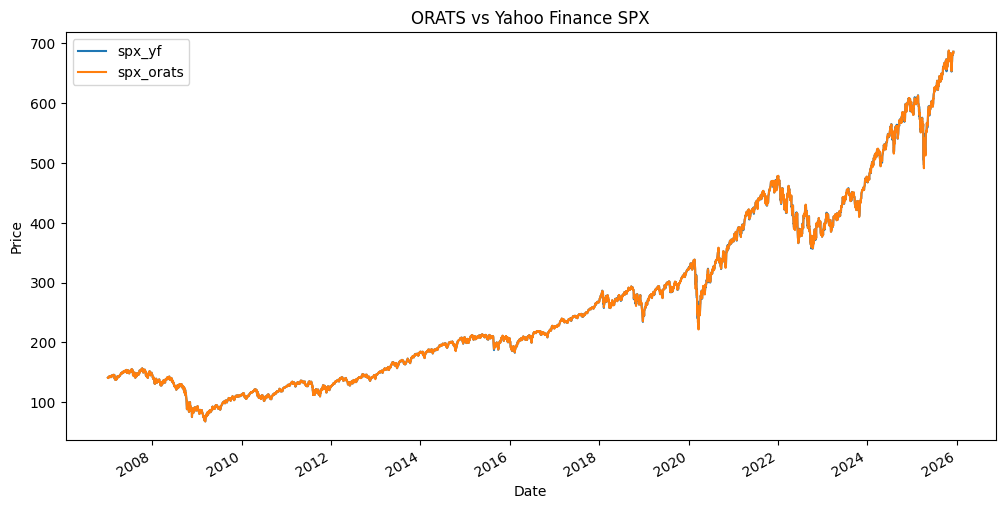

In [53]:
spx.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ORATS vs Yahoo Finance SPX")
plt.show()

# **Parity-Implied Forward Index Price Check**

For SPX index options, the cash index level is observable, but the
per-maturity forward price used in option pricing is not directly quoted.
ORATS therefore infers a forward price for each expiry using put–call parity.

As a sanity check, we:

- Compare the **number of distinct forward prices per trade date** to the
  **number of expiries** (they should be close).
- Check that for a given `(trade_date, expiry_date)` the implied forward is
  essentially **unique across strikes**.

Small deviations across strikes are expected due to noise and microstructure.
Large discrepancies or a very messy forward surface would suggest potential
data or modelling issues.

## Match between nb of expiries and future implied Prices

In [54]:
underlying_checks_expiry_match = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("underlying_price").n_unique().alias("n_spot_values"),
        pl.col("expiry_date").n_unique().alias("n_expiries"),
        pl.col("underlying_price").min().alias("spot_min"),
        pl.col("underlying_price").max().alias("spot_max"),
    )
    .sort("trade_date")
)

underlying_checks_expiry_match.filter(pl.col("n_spot_values") != pl.col("n_expiries"))

trade_date,n_spot_values,n_expiries,spot_min,spot_max
date,u32,u32,f64,f64
2007-01-03,1,6,141.37,141.37
2007-01-04,1,6,141.67,141.67
2007-01-05,1,6,140.54,140.54
2007-01-08,1,6,141.19,141.19
2007-01-09,1,6,141.07,141.07
…,…,…,…,…
2025-12-01,1,21,680.73,680.73
2025-12-02,1,22,682.52,682.52
2025-12-03,1,23,684.5,684.5


## Check for the nb of future implied prices across expiries

In [55]:
underlying_by_expiry = (
    df
    .group_by("trade_date", "expiry_date")
    .agg(
        pl.col("underlying_price").n_unique().alias("n_spot_values"),
        pl.col("underlying_price").min().alias("u_min"),
        pl.col("underlying_price").max().alias("u_max"),
    )
    .with_columns(
        (pl.col("u_max") - pl.col("u_min")).alias("abs_range"),
        ((pl.col("u_max") - pl.col("u_min")) / pl.col("u_min")).alias("rel_range"),
    )
    .sort("abs_range", descending=True)
)

expiry_viol = underlying_by_expiry.filter(pl.col("n_spot_values") > 1)
expiry_viol

trade_date,expiry_date,n_spot_values,u_min,u_max,abs_range,rel_range
date,date,u32,f64,f64,f64,f64


# **Risk free rate check**

As a hard error check we should expect non neagitve and not to crazy interest rates.
We should also expect one single rf per day per maturity.
However across maturities we could have more than one (term strcuture of interest rate).

## Global RF value sanity checks

In [56]:
rf_value_summary = (
    df
    .select(
        pl.len().alias("n_rows"),
        (pl.col("risk_free_rate") < 0).sum().alias("n_rf_negative"),
        (pl.col("risk_free_rate") > 0.10).sum().alias("n_rf_gt_10pct"),   # > 10%
        (pl.col("risk_free_rate") > 1.00).sum().alias("n_rf_gt_100pct"),  # > 100%
    )
    .with_columns(
        (pl.col("n_rf_negative") / pl.col("n_rows")).alias("pct_rf_negative"),
        (pl.col("n_rf_gt_10pct") / pl.col("n_rows")).alias("pct_rf_gt_10pct"),
        (pl.col("n_rf_gt_100pct") / pl.col("n_rows")).alias("pct_rf_gt_100pct"),
    )
)

rf_value_summary

n_rows,n_rf_negative,n_rf_gt_10pct,n_rf_gt_100pct,pct_rf_negative,pct_rf_gt_10pct,pct_rf_gt_100pct
u32,u32,u32,u32,f64,f64,f64
5167888,0,0,0,0.0,0.0,0.0


## Unique RF per day per expiry sanity check

In [57]:
rf_per_expiry = (
    df
    .group_by(["trade_date", "expiry_date"])
    .agg(
        pl.col("risk_free_rate").n_unique().alias("n_rf"),
        pl.col("risk_free_rate").mean().alias("rf"),
        pl.col("dte").first().alias("dte"),
    )
    .sort(["trade_date", "expiry_date"])
)

rf_weird = rf_per_expiry.filter(pl.col("n_rf") > 1)
print('Number of mutliple risk-free rates across strikes:', rf_weird.height)
rf_weird

Number of mutliple risk-free rates across strikes: 0


trade_date,expiry_date,n_rf,rf,dte
date,date,u32,f64,i64


## Term Structure RF sanity check

In [58]:
rf_by_day = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("risk_free_rate").n_unique().alias("n_unique_rf"),
        pl.col("risk_free_rate").min().alias("rf_min"),
        pl.col("risk_free_rate").max().alias("rf_max"),
    )
    .sort("trade_date")
)

# Days where more than one RF curve is used
rf_multicurve_days = rf_by_day.filter(pl.col("n_unique_rf") > 1)

n_days_total = rf_by_day.height
n_days_multicurve = rf_multicurve_days.height
max_rf_curves_per_day = rf_multicurve_days.select("n_unique_rf").max().item()

print(
    f"Proportion of days with non-unique risk-free rates: "
    f"{n_days_multicurve / n_days_total:.4%}"
)
print("Maximum number of distinct risk-free rates on a single day:", max_rf_curves_per_day)

rf_multicurve_days

Proportion of days with non-unique risk-free rates: 99.8950%
Maximum number of distinct risk-free rates on a single day: 4


trade_date,n_unique_rf,rf_min,rf_max
date,u32,f64,f64
2007-01-03,3,0.0484,0.0509
2007-01-04,3,0.048,0.0507
2007-01-05,3,0.0481,0.0509
2007-01-08,3,0.0487,0.0513
2007-01-09,3,0.049,0.0513
…,…,…,…
2025-12-01,4,0.0361,0.0406
2025-12-02,4,0.0362,0.0398
2025-12-03,4,0.0359,0.039


Two risk-free rate are reported each day across expiries in 85% of the cases, it sugguests the use of 2 different rf across all expiries

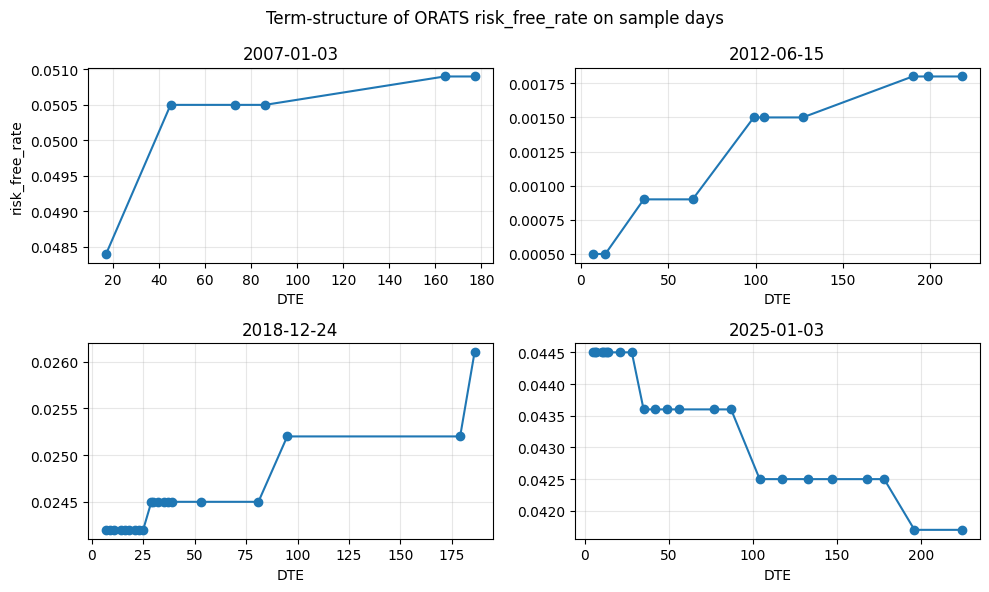

In [59]:
sample_days = [
    date(2007, 1, 3),
    date(2012, 6, 15),
    date(2018, 12, 24),
    date(2025, 1, 3),
]

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
axes = axes.ravel()

for ax, day in zip(axes, sample_days):
    sub_pd = (
        rf_per_expiry
        .filter(pl.col("trade_date") == day)
        .select("dte", "rf")
        .sort("dte")
        .to_pandas()
    )

    if sub_pd.empty:
        ax.set_axis_off()
        continue

    ax.plot(sub_pd["dte"], sub_pd["rf"], marker="o", linestyle="-", label=str(day))
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("DTE")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("risk_free_rate")
fig.suptitle("Term-structure of ORATS risk_free_rate on sample days")
fig.tight_layout()
plt.show()

Here ORATS is using a 2-point yield curve per day, one for short maturities (less than 30 DTE) and one for larger maturities (larger than 30 DTE) so as to better align with the option's maturity.

# **Implied Volatility Quality Checks**

In [60]:
iv_stats = df.select(pl.col("smoothed_iv")).describe()
iv_stats

statistic,smoothed_iv
str,f64
"""count""",5.167888e6
"""null_count""",0.0
"""mean""",0.210896
"""std""",0.094263
"""min""",0.01
"""25%""",0.143111
"""50%""",0.194009
"""75%""",0.256903
"""max""",1.431536


In [61]:
df.select(
    (pl.col("smoothed_iv") < 0).sum().alias("n_negative"),
    (pl.col("smoothed_iv") > 3.0).sum().alias("n_above_300pct"),
)

n_negative,n_above_300pct
u32,u32
0,0


## Smile shape for 10, 30 and 60 DTE

**What we’re looking for**

- Smiles are **smooth** functions of strike (no crazy spikes for single strikes).
- Shorter maturities show more curvature / higher IV during stressed periods.
- Shapes are consistent with equity index behaviour:
  - Higher IV for low deltas (OTM puts),
  - Lower IV for high deltas (OTM calls), i.e. a negative skew.
- No obvious arbitrage-like patterns:
  - IV not wildly non-monotone in wings,
  - Different maturities do not cross each other in pathological ways.

In [62]:
picked_dates = [
    date(2008, 10, 10),   # crisis
    date(2010, 12, 2),
    date(2013, 6, 13),
    date(2015, 8, 24),    # vol event
    date(2018, 2, 5),     # volmageddon
    date(2018, 9, 12),
    date(2020, 3, 16),    # covid crash
    date(2022, 6, 16),    # high vol / rates
    date(2025, 3, 3),
]

event_labels = {
    date(2008, 10, 10): "GFC stress",
    date(2015, 8, 24): "China / flash crash",
    date(2018, 2, 5):  "Volmageddon",
    date(2020, 3, 16): "Covid crash",
    date(2022, 6, 16): "Rates/Inflation stress",
}

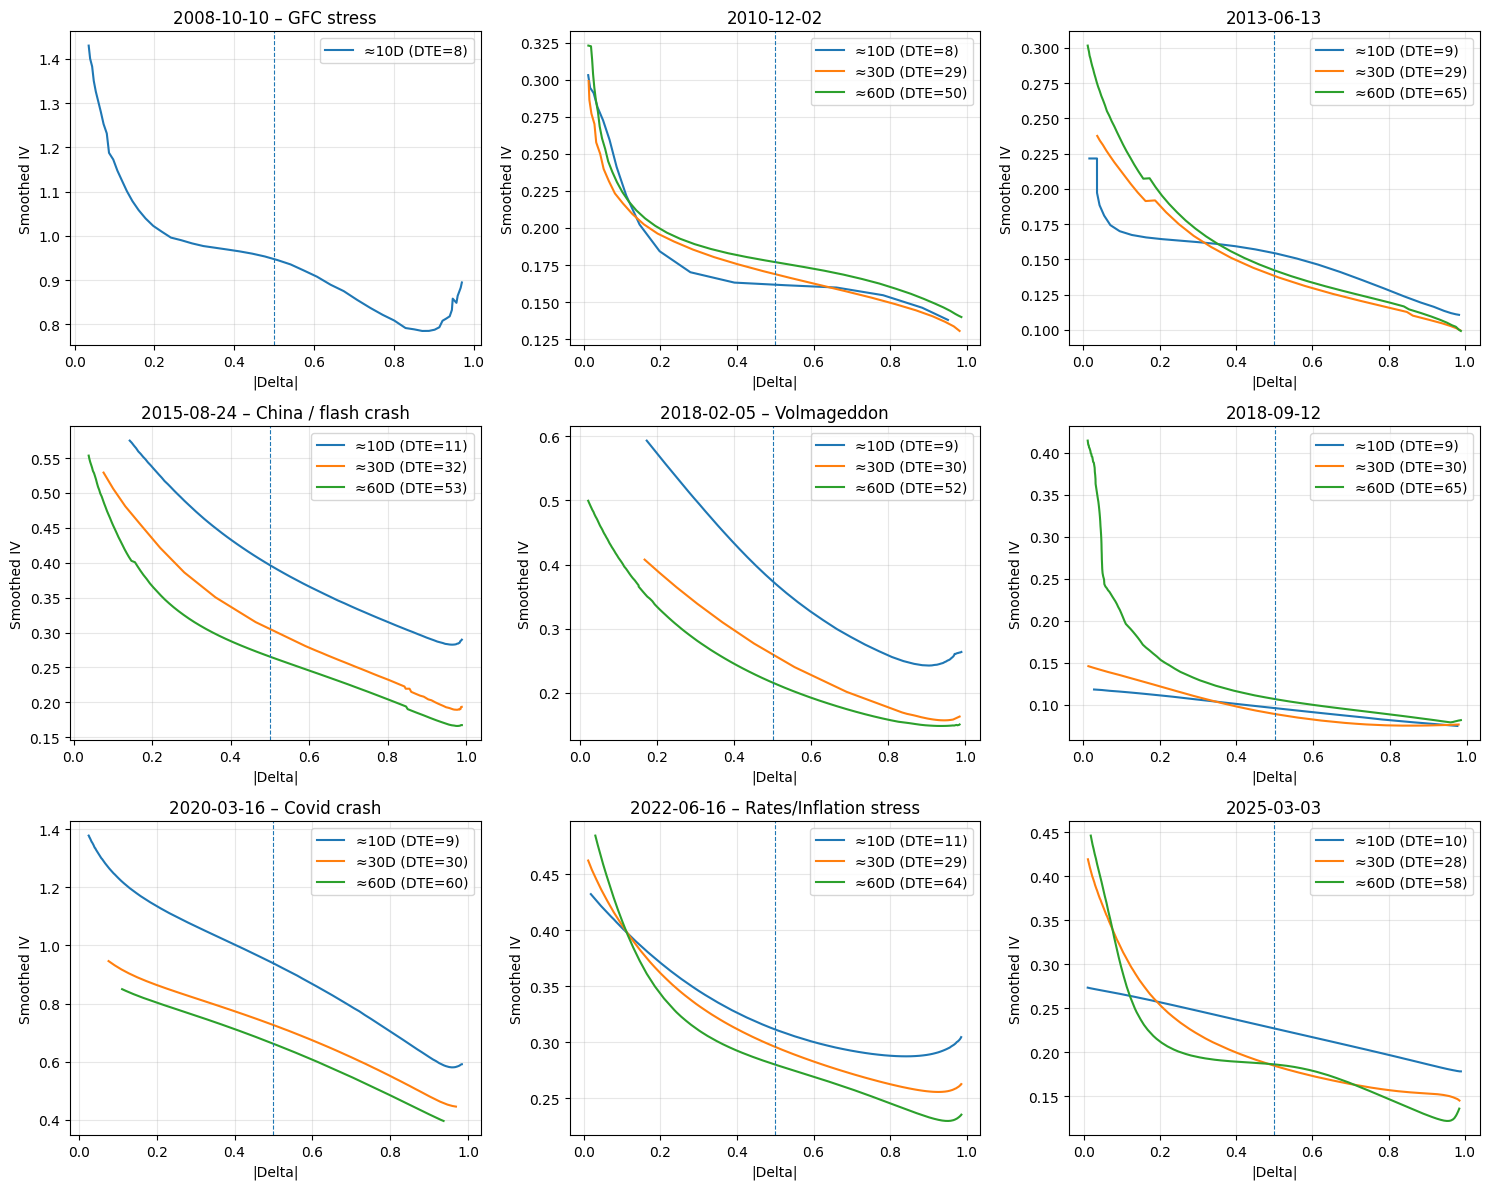

In [63]:
plot_smiles_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

The smootthed IV alreadu comes from a smoothed surface so a single linear interpolation between the reporetd strikes is enough and does not require any smoothing. Thus if we would request a particular striek we would jsut extratc the closest to the target.

## IV Term-Structure Shapes

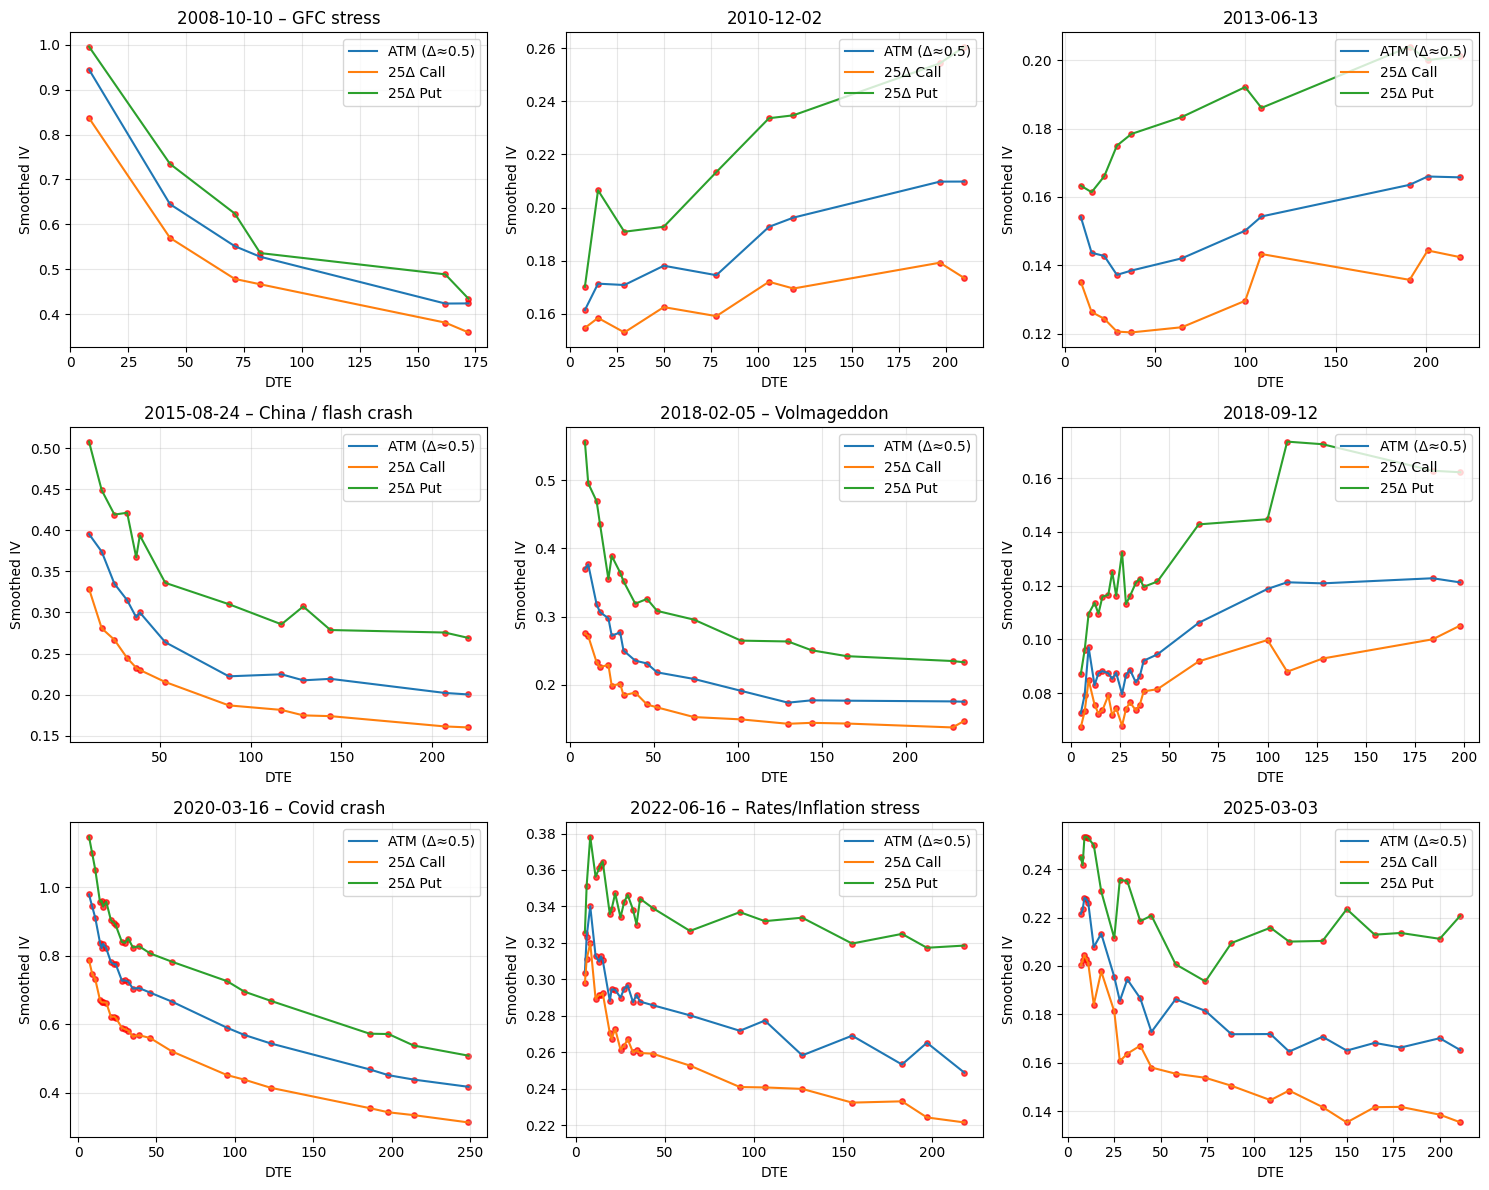

In [64]:
plot_term_structures_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

On crash dates the term strcutrue is inverted (in backwardation) while in normal regime it is upward sloping (in contango).

In contrast to the smiles whihc are already smoothed, to get a clean synthetic IV series at a specific maturity some smoothing/interpolation is needed, especially for OTM puts a smoothing is key.

# **Greeks Sanity Checks**

## Quality checks

In [65]:
checks = df.select(
    # Deltas
    (pl.col("call_delta") <= 0).sum().alias("bad_call_delta_le_0"),
    (pl.col("call_delta") >= 1).sum().alias("bad_call_delta_ge_1"),
    (pl.col("put_delta") >= 0).sum().alias("bad_put_delta_ge_0"),
    (pl.col("put_delta") <= -1).sum().alias("bad_put_delta_le_minus1"),

    # Gamma & Vega
    (pl.col("call_gamma") < 0).sum().alias("neg_call_gamma"),
    (pl.col("put_gamma") < 0).sum().alias("neg_put_gamma"),
    (pl.col("call_vega") < 0).sum().alias("neg_call_vega"),
    (pl.col("put_vega") < 0).sum().alias("neg_put_vega"),

    # Rho sign
    (pl.col("call_rho") < 0).sum().alias("call_rho_negative"),
    (pl.col("put_rho") > 0).sum().alias("put_rho_positive"),

    # Theta sign (more relaxed: count how many are positive)
    (pl.col("call_theta") > 0).sum().alias("call_theta_positive"),
    (pl.col("put_theta") > 0).sum().alias("put_theta_positive"),
)

checks

bad_call_delta_le_0,bad_call_delta_ge_1,bad_put_delta_ge_0,bad_put_delta_le_minus1,neg_call_gamma,neg_put_gamma,neg_call_vega,neg_put_vega,call_rho_negative,put_rho_positive,call_theta_positive,put_theta_positive
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,180,0,338752


In [66]:
viol_rho = (df
    .filter(pl.col("put_rho") > 0)
    .select("trade_date", "dte", "put_delta", "put_rho")
)
viol_rho

trade_date,dte,put_delta,put_rho
date,i64,f64,f64
2014-10-14,10,-0.011289,0.000124
2014-12-24,7,-0.011785,0.000163
2014-12-24,9,-0.010475,0.000082
2015-09-22,8,-0.011454,0.00009
2015-11-11,16,-0.010555,0.000365
…,…,…,…
2025-11-28,7,-0.01568,0.000224
2025-11-28,7,-0.016876,0.000066
2025-11-28,10,-0.010592,0.000288


Those violations occur only for **deep OTM puts** with **very short expiries**, and their magnitudes are tiny numerical noise.

In [67]:
viol = (df
    .filter(
        pl.col("put_rho") > 0,
        pl.col("put_delta").abs().is_between(0.05, 0.95)
    )
    .select("trade_date", "dte", "put_delta", "put_rho")
)
viol

trade_date,dte,put_delta,put_rho
date,i64,f64,f64


Inside the 5%-95% Delta band the violations completely dissapear so we cna safely ignore them.

## Greeks vs Strike

In [68]:
# 1) Pick a date & target DTE
day = date(2024, 12, 16)
dte_target = 30  # target maturity in days

sub = df_long.filter(pl.col("trade_date") == day)

# 2) Get available DTEs for that trade_date only
dtes_for_day = (
    sub
    .select(pl.col("dte").unique()).sort("dte")
    .to_series().to_list()
)

# 3) Use helper to pick the closest one (within tolerance)
dte_true = pick_closest_dte(dtes_for_day, dte_target, max_tol=10)
if dte_true is None:
    raise ValueError(f"No DTE within 10 days of target={dte_target} on {day}")

# 4) Slice that specific (day, dte) slice
sub = (
    sub
    .filter(pl.col("dte") == dte_true)
    .sort("strike")
)

S = sub.select("underlying_price").to_series().item(0)
calls = sub.filter(pl.col("option_type") == "C")
puts = sub.filter(pl.col("option_type") == "P")

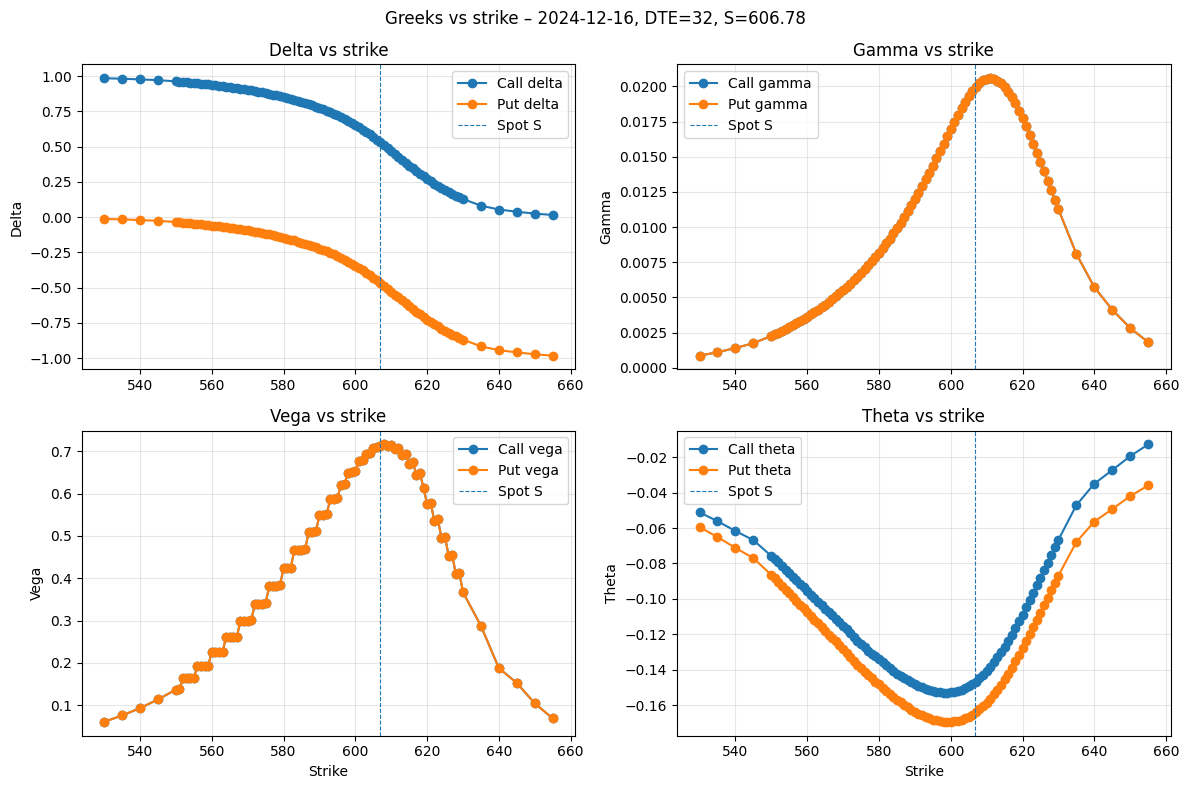

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
ax_d, ax_g = axes[0]
ax_v, ax_t = axes[1]

plots = [
    ("delta", ax_d, "Delta", "Delta vs strike"),
    ("gamma", ax_g, "Gamma", "Gamma vs strike"),
    ("vega",  ax_v, "Vega",  "Vega vs strike"),
    ("theta", ax_t, "Theta", "Theta vs strike"),
]

for col, ax, ylabel, title in plots:
    ax.plot(calls["strike"], calls[col], label=f"Call {col}", marker="o")
    ax.plot(puts["strike"],  puts[col],  label=f"Put {col}",  marker="o")

    # vertical line at spot
    ax.axvline(S, linestyle="--", linewidth=0.8, label="Spot S")

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend()

ax_v.set_xlabel("Strike")
ax_t.set_xlabel("Strike")

fig.suptitle(f"Greeks vs strike – {day}, DTE={dte_true}, S={S:.2f}")
fig.tight_layout()
plt.show()

# **Model-driven / arbitrage checks**

Before looking at theoretical arbitrage violations, it is important to
remember that **not all of the option chain is realistically tradable for us**.

- In practice we care mainly about:
  - **ATM options** (both calls and puts),
  - **OTM calls and puts**, and
  - some **deep OTM puts** (typically not below ~10-delta).
- Deep ITM options (|Δ| ≈ 1) are usually **not attractive for vol trading**:
  they behave almost like the underlying (delta ≈ ±1, other Greeks ≈ 0),
  so it is often cleaner to trade the underlying directly.

On the maturity side:

- Our horizon of interest is roughly **10–60 days to expiry**:
  - very short maturities (< 10 DTE) suffer from extreme time decay,
  - very long maturities (> 60 DTE) often have low VRP and liquidity is thinner.

Therefore:

- **Violations in far wings (very small or very large delta) and very short/long DTE
  are much less relevant** than violations inside our core tradable region
  (e.g. 10–90Δ, 10–60 DTE).

To make this concrete, we first visualise how **liquidity (volume / open interest)**
is distributed across moneyness and maturity.

## Volume for Calls/Puts by $\Delta$ Moneyness

/Users/anthony/VSCode/python_project/volatility_trading/src/volatility_trading/etl/orats/qc/orats_qc_plotting.py:229: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = vol_by_delta.pivot_table(


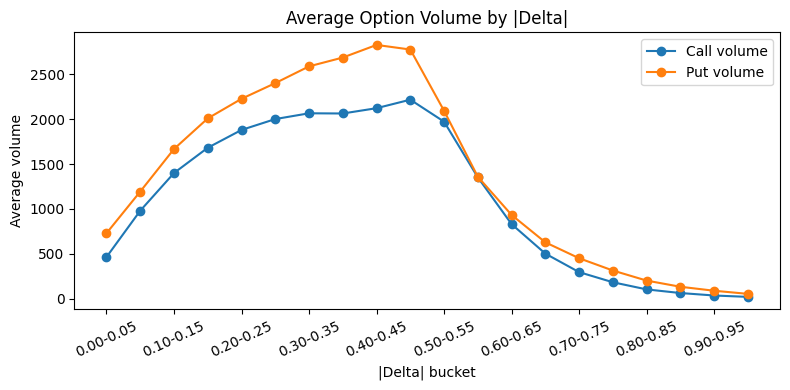

In [92]:
plot_avg_volume_by_delta(df_long)

As you can see we mostly care baout the 10-90 Delta region outside options have low liquidity whihc is translated by 
stale quotes and large spreads thus poentila arbitrage in those regions are usually not tradeable.

## Volume/Open Interest by DTE

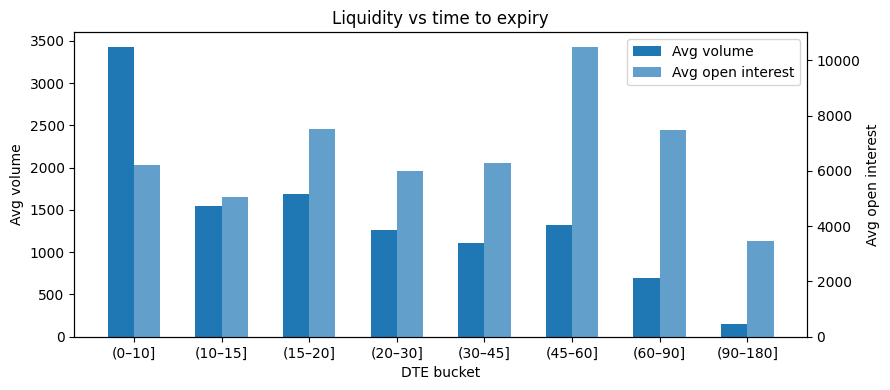

In [93]:
plot_liquidity_by_dte(df_long)

Most of the options we care are between 10 and 60 DTE below that options have too alrge gamma and are usually between for intraday trades and larger than 60 DTE low liquidity and open interest.

# **Put–Call Parity checks**

We start from **European put–call parity** with continuous dividend yield $q$ and
risk-free rate $r$:

$$
C - P = S e^{-qT} - K e^{-rT},
$$

where

- $C, P$ = call and put prices  
- $S$     = spot/underlying price  
- $K$     = strike  
- $T$     = time to expiry in years (our `yte`)  
- $q$     = dividend yield (`dividend_yield`)  
- $r$     = risk-free rate (`risk_free_rate`).

In [94]:
disc_r = (-df["risk_free_rate"] * df["yte"]).exp()
disc_q = (-df["dividend_yield"] * df["yte"]).exp()

## 2.1 Price parity (mid prices)

We first check whether **mid prices** are roughly consistent with parity:

$$
C_{mid} - P_{mid} = S e^{-qT} - K e^{-rT},
$$

i.e.

$$
C_{mid} - P_{mid} - \bigl(S e^{-qT} - K e^{-rT}\bigr) \approx 0.
$$

We compute this difference for each (trade_date, expiry, strike) and inspect
its distribution (mean, percentiles) to make sure there is no systematic drift.
Small deviations are expected because of bid–ask, American exercise and
microstructure noise.

In [98]:
parity_df = (
    df
    .with_columns(
        disc_q = (-pl.col("dividend_yield") * pl.col("yte")).exp(),
        disc_r = (-pl.col("risk_free_rate") * pl.col("yte")).exp(),
    )
    .with_columns(
        lhs = pl.col("call_mid_price") - pl.col("put_mid_price"),
        rhs = pl.col("underlying_price") * pl.col("disc_q") - pl.col("strike") * pl.col("disc_r"),
    )
    .with_columns(
        parity_diff = pl.col("lhs") - pl.col("rhs"),
    )
)

# quick numeric summary of the deviation
parity_summary = (
    parity_df
    .select(
        pl.col("parity_diff"),
    ).describe()
)

parity_summary

statistic,parity_diff
str,f64
"""count""",5.167888e6
"""null_count""",0.0
"""mean""",0.248105
"""std""",1.444381
"""min""",-96.153626
"""25%""",-0.017047
"""50%""",0.179784
"""75%""",0.850402
"""max""",21.223839


In [99]:
ABS_THRESH = 0.5  # index points

parity_flags = (
    parity_df
    .filter(
        pl.col("parity_diff").abs() > ABS_THRESH,
        pl.col("dte").is_between(10, 60),
        pl.col("call_delta").is_between(0.1, 0.9),
    )
)
parity_flags

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield,disc_q,disc_r,lhs,rhs,parity_diff
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-02-17,45,0.12329,141.37,141.37,147.0,561,366,5249,761,0.35,0.375,0.37,0.4,0.133333,5.5,5.6,5.63,5.7,0.035714,0.091463,0.09163,0.05451,0.157908,0.05329,-0.015348,0.115937,0.027067,-0.842092,0.05329,-0.03556,0.115937,-0.153044,0.0505,0.0,1.0,0.993793,-5.225,-4.7176,-0.5074
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,147.0,837,162,5773,666,0.3,0.35,0.37,0.4,0.285714,5.2,5.3,5.33,5.4,0.037736,0.089038,0.08699,0.05253,0.162653,0.056342,-0.01546,0.128629,0.027333,-0.837347,0.056342,-0.035635,0.128629,-0.148802,0.0504,0.0,1.0,0.993943,-4.95,-4.439577,-0.510423
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,148.0,42,40,1943,27,0.15,0.175,0.21,0.2,0.285714,6.2,6.3,6.33,6.4,0.031746,0.085452,0.08167,0.05866,0.103968,0.043046,-0.010644,0.093091,0.0175087,-0.896032,0.043046,-0.030956,0.093091,-0.159825,0.0504,0.0,1.0,0.993943,-6.125,-5.43352,-0.69148
"""SPY""",2007-01-08,2007-02-17,40,0.10959,141.19,141.19,147.0,117,0,6600,266,0.2,0.225,0.19,0.25,0.222222,5.7,5.8,5.81,5.9,0.034483,0.082465,0.08583,0.05944,0.105832,0.047555,-0.011045,0.090143,0.016165,-0.894168,0.047555,-0.031391,0.090143,-0.144038,0.0508,0.0,1.0,0.994448,-5.575,-4.9939,-0.5811
"""SPY""",2007-01-09,2007-02-17,39,0.10685,141.07,141.07,147.0,66,478,6654,251,0.15,0.2,0.2,0.25,0.5,5.9,6.0,5.93,6.1,0.033333,0.087144,0.08643,0.06427,0.106086,0.045674,-0.011484,0.084944,0.015776,-0.893914,0.045674,-0.031833,0.084944,-0.140443,0.0508,0.0,1.0,0.994587,-5.8,-5.134249,-0.665751
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,721.0,2,0,106,0,2.6,2.61,2.6,2.62,0.007663,35.41,36.865,35.88,38.32,0.078937,0.105609,0.11822,0.11748,0.130857,0.007509,-0.058933,0.552247,0.134849,-0.866601,0.007509,-0.100722,0.552247,-0.96503,0.0371,0.016588,0.997458,0.994324,-34.255,-33.040471,-1.214529
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,722.0,1,0,107,2,2.43,2.445,2.45,2.46,0.01227,36.29,37.755,36.79,39.22,0.077606,0.10525,0.11786,0.07404,0.123026,0.007214,-0.056141,0.554172,0.126823,-0.874432,0.007214,-0.098031,0.554172,-0.974583,0.0371,0.016588,0.997458,0.994324,-35.31,-34.034796,-1.275204
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,723.0,2,0,258,0,2.28,2.295,2.29,2.31,0.013072,37.15,38.635,37.71,40.12,0.076873,0.104947,0.11764,0.0745,0.115286,0.006917,-0.053424,0.556062,0.118887,-0.882172,0.006917,-0.095415,0.556062,-0.984044,0.0371,0.016588,0.997458,0.994324,-36.34,-35.02912,-1.31088


In [100]:
EPS = 1e-6

parity_flags_spread = (
    parity_flags
    .with_columns(
        total_spread = (
            (pl.col("call_ask_price") - pl.col("call_bid_price")) +
            (pl.col("put_ask_price")  - pl.col("put_bid_price"))
        ),
    )
    .filter(
        pl.col("parity_diff").abs() > 1 * pl.col("total_spread"),
    )
)

parity_flags_spread

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield,disc_q,disc_r,lhs,rhs,parity_diff,total_spread
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-02-17,45,0.12329,141.37,141.37,147.0,561,366,5249,761,0.35,0.375,0.37,0.4,0.133333,5.5,5.6,5.63,5.7,0.035714,0.091463,0.09163,0.05451,0.157908,0.05329,-0.015348,0.115937,0.027067,-0.842092,0.05329,-0.03556,0.115937,-0.153044,0.0505,0.0,1.0,0.993793,-5.225,-4.7176,-0.5074,0.25
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,147.0,837,162,5773,666,0.3,0.35,0.37,0.4,0.285714,5.2,5.3,5.33,5.4,0.037736,0.089038,0.08699,0.05253,0.162653,0.056342,-0.01546,0.128629,0.027333,-0.837347,0.056342,-0.035635,0.128629,-0.148802,0.0504,0.0,1.0,0.993943,-4.95,-4.439577,-0.510423,0.3
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,148.0,42,40,1943,27,0.15,0.175,0.21,0.2,0.285714,6.2,6.3,6.33,6.4,0.031746,0.085452,0.08167,0.05866,0.103968,0.043046,-0.010644,0.093091,0.0175087,-0.896032,0.043046,-0.030956,0.093091,-0.159825,0.0504,0.0,1.0,0.993943,-6.125,-5.43352,-0.69148,0.25
"""SPY""",2007-01-08,2007-02-17,40,0.10959,141.19,141.19,147.0,117,0,6600,266,0.2,0.225,0.19,0.25,0.222222,5.7,5.8,5.81,5.9,0.034483,0.082465,0.08583,0.05944,0.105832,0.047555,-0.011045,0.090143,0.016165,-0.894168,0.047555,-0.031391,0.090143,-0.144038,0.0508,0.0,1.0,0.994448,-5.575,-4.9939,-0.5811,0.25
"""SPY""",2007-01-09,2007-02-17,39,0.10685,141.07,141.07,147.0,66,478,6654,251,0.15,0.2,0.2,0.25,0.5,5.9,6.0,5.93,6.1,0.033333,0.087144,0.08643,0.06427,0.106086,0.045674,-0.011484,0.084944,0.015776,-0.893914,0.045674,-0.031833,0.084944,-0.140443,0.0508,0.0,1.0,0.994587,-5.8,-5.134249,-0.665751,0.3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,713.0,148,0,352,3,4.27,4.28,4.28,4.29,0.004673,29.84,30.09,30.1,30.34,0.016617,0.110564,0.1208,0.12396,0.209488,0.009719,-0.084867,0.744367,0.215084,-0.78797,0.009719,-0.125848,0.744367,-0.872592,0.0371,0.016588,0.997458,0.994324,-25.81,-25.085877,-0.724123,0.52
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,714.0,1,0,171,2,4.02,4.035,4.04,4.05,0.007435,30.65,30.91,30.92,31.17,0.016823,0.10978,0.12042,0.12409,0.198599,0.009473,-0.081394,0.747224,0.204008,-0.798859,0.009473,-0.122475,0.747224,-0.885193,0.0371,0.016588,0.997458,0.994324,-26.875,-26.080201,-0.794799,0.55
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,715.0,284,30,4694,13,3.78,3.795,3.79,3.81,0.007905,31.53,31.755,31.74,31.98,0.014171,0.109029,0.12011,0.12447,0.187628,0.009217,-0.077959,0.750083,0.1928418,-0.80983,0.009217,-0.119142,0.750083,-0.897885,0.0371,0.016588,0.997458,0.994324,-27.96,-27.074526,-0.885474,0.48


In [102]:
del parity_df
gc.collect()

NameError: name 'parity_df' is not defined

Check parity usign mid prices and do bucket nalaysis across Delta/DTE

# **Arbitrage bounds for call & put prices**

For a European option on an underlying with spot $S$, strike $K$, maturity $T$,
risk–free rate $r$ and continuous dividend yield $q$, the **no-arbitrage price
bounds** in a simple Black–Scholes world are:
Naely option prices should be worht at least the instrisic value (isnce Price = Instric + extrinsic (time+vol))
Obvious upper bounds are that they msut worth less than underlying for call (in case deep ITM) and the strike for put (in case deep ITM for put too)


- **Discounted spot and strike**  
  $$
  \tilde S = S e^{-qT}, \qquad \tilde K = K e^{-rT}.
  $$

- **Call bounds**  
  $$
  C \;\ge\; \max\bigl(0,\;\tilde S - \tilde K\bigr), \qquad
  C \;\le\; \tilde S.
  $$

- **Put bounds**  
  $$
  P \;\ge\; \max\bigl(0,\;\tilde K - \tilde S\bigr), \qquad
  P \;\le\; \tilde K.
  $$


Here we are very restrcitive for uper bound violations as they would sugguets that our option data is garbage.

In [ ]:
TOL = 1e-6  # small numerical tolerance

# --- 1) Build discounted spot & strike -------------------------------------
df_bounds = (
    df.lazy()
    .filter(
        pl.col("call_delta").is_between(0.1, 0.9),
        pl.col("dte").is_between(10, 60),
    )
    .with_columns(
        disc_r = (-pl.col("risk_free_rate") * pl.col("yte")).exp(),
        disc_q = (-pl.col("dividend_yield") * pl.col("yte")).exp(),
    ).with_columns(
        spot_disc  = pl.col("underlying_price") * pl.col("disc_q") * pl.col("disc_r"),
        strike_disc = pl.col("strike") * pl.col("disc_r"),      # K e^{-rT}
    )
)

# --- 2) Theoretical lower/upper bounds -------------------------------------
df_bounds = df_bounds.with_columns(
    # Call bounds
    call_lb = pl.max_horizontal(
        pl.lit(0.0),
        pl.col("spot_disc") - pl.col("strike_disc"),
    ),
    call_ub = pl.col("spot_disc"),

    # Put bounds
    put_lb = pl.max_horizontal(
        pl.lit(0.0),
        pl.col("strike_disc") - pl.col("spot_disc"),
    ),
    put_ub = pl.col("strike_disc"),
)

# --- 3) Flag violations -----------------------------------------------------
df_bounds = df_bounds.with_columns(
    call_lb_violation = pl.col("call_mid_price") < (pl.col("call_lb") - TOL),
    call_ub_violation = pl.col("call_mid_price") > (pl.col("call_ub") + TOL),

    put_lb_violation = pl.col("put_mid_price") < (pl.col("put_lb") - TOL),
    put_ub_violation = pl.col("put_mid_price") > (pl.col("put_ub") + TOL),
)

# --- 4) Summary counts ------------------------------------------------------
summary = df_bounds.select(
    pl.len().alias("n_total"),

    pl.col("call_lb_violation").sum().alias("n_call_lb_viol"),
    pl.col("call_ub_violation").sum().alias("n_call_ub_viol"),

    pl.col("put_lb_violation").sum().alias("n_put_lb_viol"),
    pl.col("put_ub_violation").sum().alias("n_put_ub_viol"),
).collect()

summary

n_total,n_call_lb_viol,n_call_ub_viol,n_put_lb_viol,n_put_ub_viol
u32,u32,u32,u32,u32
1339269,93,0,15972,0


In [146]:
summarize_monotonicity_by_region(
    options_chain_wide_to_long(df_bounds).collect().filter(pl.col("option_type") == "P"), 
    violation_col="lb_violation"
)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(30, 60]""","""(0.75, 0.9]""",11219,90896,0.123427,0.702417,0.008377
"""(10, 30]""","""(0.75, 0.9]""",3900,116879,0.033368,0.244177,0.002912
"""(0, 10]""","""(0.75, 0.9]""",117,6038,0.019377,0.007325,0.000087
"""(30, 60]""","""(0.5, 0.75]""",623,133327,0.004673,0.039006,0.000465
"""(10, 30]""","""(0.5, 0.75]""",105,154771,0.000678,0.006574,0.000078
…,…,…,…,…,…,…
"""(10, 30]""","""(0.1, 0.25]""",0,233554,0.0,0.0,0.0
"""(30, 60]""","""(0, 0.1]""",0,4076,0.0,0.0,0.0
"""(10, 30]""","""(0, 0.1]""",0,2113,0.0,0.0,0.0


Most of the lb violations for put happen deep ITM so those violations are not a big issue.

## 2. Strike & maturity monotonicity checks

In a frictionless European setting (Black–Scholes with continuous dividend yield),
option prices satisfy a few monotonicity properties that are tightly linked to
vertical‐spread and calendar‐spread arbitrage.

In real data (NBBO quotes, American exercise, discrete dividends, microstructure
noise), these conditions can be **slightly violated**, so we treat them as
**soft sanity checks**:

- we **count** how many violations occur;
- we look at where they happen in the surface (DTE, moneyness);
- we make sure there is no obvious systematic data issue.

### 2.1 Vertical spread arbitrage (strike monotonicity)

Fix a trade date and an expiration (fixed maturity $T$). As a function of strike
$K$:

- **Calls** must be non-increasing in $K$
  $$
  C(K_1) \ge C(K_2) \quad \text{if } K_1 < K_2.
  $$
  Otherwise a vertical call spread would be mispriced.

- **Puts** must be non-decreasing in $K$
  $$
  P(K_1) \le P(K_2) \quad \text{if } K_1 < K_2.
  $$

We flag a violation whenever, within a given $(\text{trade\_date}, \text{expiry})$
bucket, the call (resp. put) mid price increases (resp. decreases) as strike
increases.

### Call Strike Monoticity Violations

In [137]:
# 1) Flag violations for calls
df_calls_qc = flag_strike_monotonicity_long(df_long, "C")

# 2) Summary by (DTE, delta) region
viol_by_region_calls = summarize_monotonicity_by_region(df_calls_qc)

# 3) Global percentage of violations among calls
n_viol_calls = df_calls_qc["monot_violation"].sum()
pct_viol_calls_strike = n_viol_calls / df_calls_qc.height

print(f"Strike monotonicity violations for calls: {pct_viol_calls_strike:.4%}")
viol_by_region_calls.head(10)

Strike monotonicity violations for calls: 0.0340%


dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(60, inf]""","""(0, 0.1]""",615,274041,0.002244,0.34963,0.000119
"""(0, 10]""","""(0, 0.1]""",77,63880,0.001205,0.043775,0.000015
"""(30, 60]""","""(0, 0.1]""",146,125133,0.001167,0.083002,0.000028
"""(10, 30]""","""(0, 0.1]""",200,187311,0.001068,0.113701,0.000039
"""(60, inf]""","""(0.1, 0.25]""",201,241597,0.000832,0.114269,0.000039
"""(30, 60]""","""(0.25, 0.5]""",46,133290,0.000345,0.026151,0.000009
"""(0, 10]""","""(0.1, 0.25]""",12,37073,0.000324,0.006822,0.000002
"""(10, 30]""","""(0.25, 0.5]""",50,154751,0.000323,0.028425,0.00001
"""(10, 30]""","""(0.1, 0.25]""",34,117602,0.000289,0.019329,0.000007


The 5 highest violations appear deep OTM (delta <= 0.1) for calls while the next 5 highest appear for large maturity options (DTE >= 60). Thus those vioaltions are not probablematic.

In [138]:
df_calls_qc.filter(
    pl.col("delta").abs().is_between(0.1, 0.9),
    pl.col("dte").is_between(10, 60),
).select(
    pl.col("monot_violation").sum() / pl.len()
).item()

0.0001971224600883019

In [128]:
del df_calls_qc; gc.collect()

2351

### Put Strike Monoticity Violations

In [129]:
# 1) Flag violations for puts
df_puts_qc = flag_strike_monotonicity_long(df_long, "P")

# 2) Summary by (DTE, delta) region
viol_by_region_puts = summarize_monotonicity_by_region(df_puts_qc)

# 3) Global percentage of violations among puts
n_viol_puts = df_puts_qc["monot_violation"].sum()
pct_viol_puts_strike = n_viol_puts / df_puts_qc.height

print(f"Strike monotonicity violations for puts: {pct_viol_puts_strike:.4%}")
viol_by_region_puts.head(10)

Strike monotonicity violations for puts: 0.0293%


dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(0, 10]""","""(0, 0.1]""",107,121845,0.000878,0.070674,0.000021
"""(10, 30]""","""(0, 0.1]""",186,300348,0.000619,0.122853,0.000036
"""(30, 60]""","""(0, 0.1]""",136,232461,0.000585,0.089828,0.000026
"""(10, 30]""","""(0.5, 0.75]""",77,154771,0.000498,0.050859,0.000015
"""(30, 60]""","""(0.5, 0.75]""",65,133327,0.000488,0.042933,0.000013
"""(0, 10]""","""(0.75, 0.9]""",15,37139,0.000404,0.009908,0.000003
"""(30, 60]""","""(0.1, 0.25]""",73,187922,0.000388,0.048217,0.000014
"""(10, 30]""","""(0.75, 0.9]""",45,118105,0.000381,0.029723,0.000009
"""(0, 10]""","""(0.5, 0.75]""",15,45942,0.000326,0.009908,0.000003


All violatiosn appear in irrelevent tradeable put surface region except for the bucket DTE=(30, 60], DELTA=(0.1, 0.25] which is ineterts for skew based trades (e.g. Risk reversal structures) however the pct of vioaltions across lal puts is merely 0.5%.

In [130]:
del df_puts_qc; gc.collect()

0

### 2.3 Calendar arbitrage (maturity monotonicity)

Fix a trade date and a strike $K$. As a function of maturity $T$:

- **European calls** should be non-decreasing in $T$:
  $$
  C(T_1) \le C(T_2) \quad \text{if } T_1 < T_2.
  $$

- **European puts** should also be non-decreasing in $T$ under standard
  assumptions.

If a longer-dated option is strictly cheaper than a shorter-dated option with the
same strike and underlying, you can construct a calendar spread with negative
cost and non-negative payoff → calendar arbitrage.

We flag a violation whenever, for fixed $(\text{trade\_date}, \text{strike})$,
the mid price **decreases** as DTE increases.

In [131]:
# 1) Flag violations for calls
df_calls_qc = flag_maturity_monotonicity_long(df_long, "C")

# 2) Summary by (DTE, delta) region
viol_by_region_calls = summarize_monotonicity_by_region(df_calls_qc)

# 3) Global percentage of violations among calls
n_viol_calls = df_calls_qc["monot_violation"].sum()
pct_viol_calls_strike = n_viol_calls / df_calls_qc.height

print(f"Maturity monotonicity violations for calls: {pct_viol_calls_strike:.4%}")
viol_by_region_calls.head(10)

Maturity monotonicity violations for calls: 0.4202%


dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(10, 30]""","""(0.9, 1]""",6684,298235,0.022412,0.307834,0.001293
"""(0, 10]""","""(0.9, 1]""",2537,121634,0.020858,0.116842,0.000491
"""(30, 60]""","""(0.9, 1]""",2728,228385,0.011945,0.125639,0.000528
"""(60, inf]""","""(0.9, 1]""",4968,474730,0.010465,0.228803,0.000961
"""(0, 10]""","""(0.75, 0.9]""",322,67556,0.004766,0.01483,0.000062
"""(10, 30]""","""(0.75, 0.9]""",1099,234531,0.004686,0.050615,0.000213
"""(60, inf]""","""(0.75, 0.9]""",1397,674115,0.002072,0.064339,0.00027
"""(30, 60]""","""(0.75, 0.9]""",306,189837,0.001612,0.014093,0.000059
"""(60, inf]""","""(0, 0.1]""",393,274041,0.001434,0.0181,0.000076


In [134]:
n_viol_puts

84833

In [132]:
# 1) Flag violations for puts
df_puts_qc = flag_maturity_monotonicity_long(df_long, "P")

# 2) Summary by (DTE, delta) region
viol_by_region_puts = summarize_monotonicity_by_region(df_puts_qc)

# 3) Global percentage of violations among puts
n_viol_puts = df_puts_qc["monot_violation"].sum()
pct_viol_puts = n_viol_puts / df_puts_qc.height

print(f"Maturity monotonicity violations for puts: {pct_viol_puts:.4%}")
viol_by_region_puts.head(10)

Maturity monotonicity violations for puts: 1.6415%


dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(10, 30]""","""(0.9, 1]""",23938,186085,0.12864,0.282178,0.004632
"""(0, 10]""","""(0.9, 1]""",7904,63723,0.124037,0.093171,0.001529
"""(60, inf]""","""(0.9, 1]""",28150,258848,0.108751,0.331828,0.005447
"""(30, 60]""","""(0.9, 1]""",12486,123258,0.1013,0.147183,0.002416
"""(60, inf]""","""(0.75, 0.9]""",7447,244173,0.030499,0.087784,0.001441
"""(30, 60]""","""(0.75, 0.9]""",1532,92771,0.016514,0.018059,0.000296
"""(10, 30]""","""(0.75, 0.9]""",1329,118105,0.011253,0.015666,0.000257
"""(0, 10]""","""(0.75, 0.9]""",232,37139,0.006247,0.002735,0.000045
"""(60, inf]""","""(0.5, 0.75]""",746,382576,0.00195,0.008794,0.000144


In [139]:
df_puts_qc.filter(
    pl.col("delta").abs().is_between(0.1, 0.9),
    pl.col("dte").is_between(10, 60),
).select(
    pl.col("monot_violation").sum() / pl.len()
).item()

0.0026067120402704456